<a href="https://colab.research.google.com/github/Padmini-Matam/Metastatic-Cancer-Detection/blob/main/Cancer_Image_Detection_With_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade torch


In [ ]:
from torch.cuda import is_available, get_device_name

if is_available():
    print(f"The environment has a compatible GPU ({get_device_name()}) available.")
else:
    print(f"The environment does NOT have a compatible GPU model available.")


The environment has a compatible GPU (Tesla T4) available.


In [ ]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

%matplotlib inline

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset, random_split
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

In [ ]:
# This function will allow us to easily plot tensor data
from numpy import clip , array
from matplotlib import pyplot as plt
from torch import Tensor

def imshow(inp: Tensor) -> None:
    """Imshow for Tensor."""
    inp = inp.cpu().numpy()
    inp = inp.transpose((1, 2, 0))
    mean = array([0.485, 0.456, 0.406])
    std = array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()

In [ ]:
# loading images from zip file (it takes few minutes)

import zipfile
from tqdm import tqdm

with zipfile.ZipFile("/content/drive/MyDrive/sample data/data_sample.zip", "r") as zip_ref:
    # get the total number of files in the zip file
    total_files = len(zip_ref.infolist())

    # iterate over the files in the zip file and extract them
    for file in tqdm(zip_ref.infolist(), total=total_files):
        zip_ref.extract(file, "data_sample")

# removing one unwanted file in the data_sample folder
os.remove("data_sample/data_sample/.DS_Store")

100%|██████████| 8021/8021 [00:04<00:00, 1917.82it/s]


In [ ]:
## Load the label of data
labels_df = pd.read_csv("/content/drive/MyDrive/sample data/labels.csv")
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


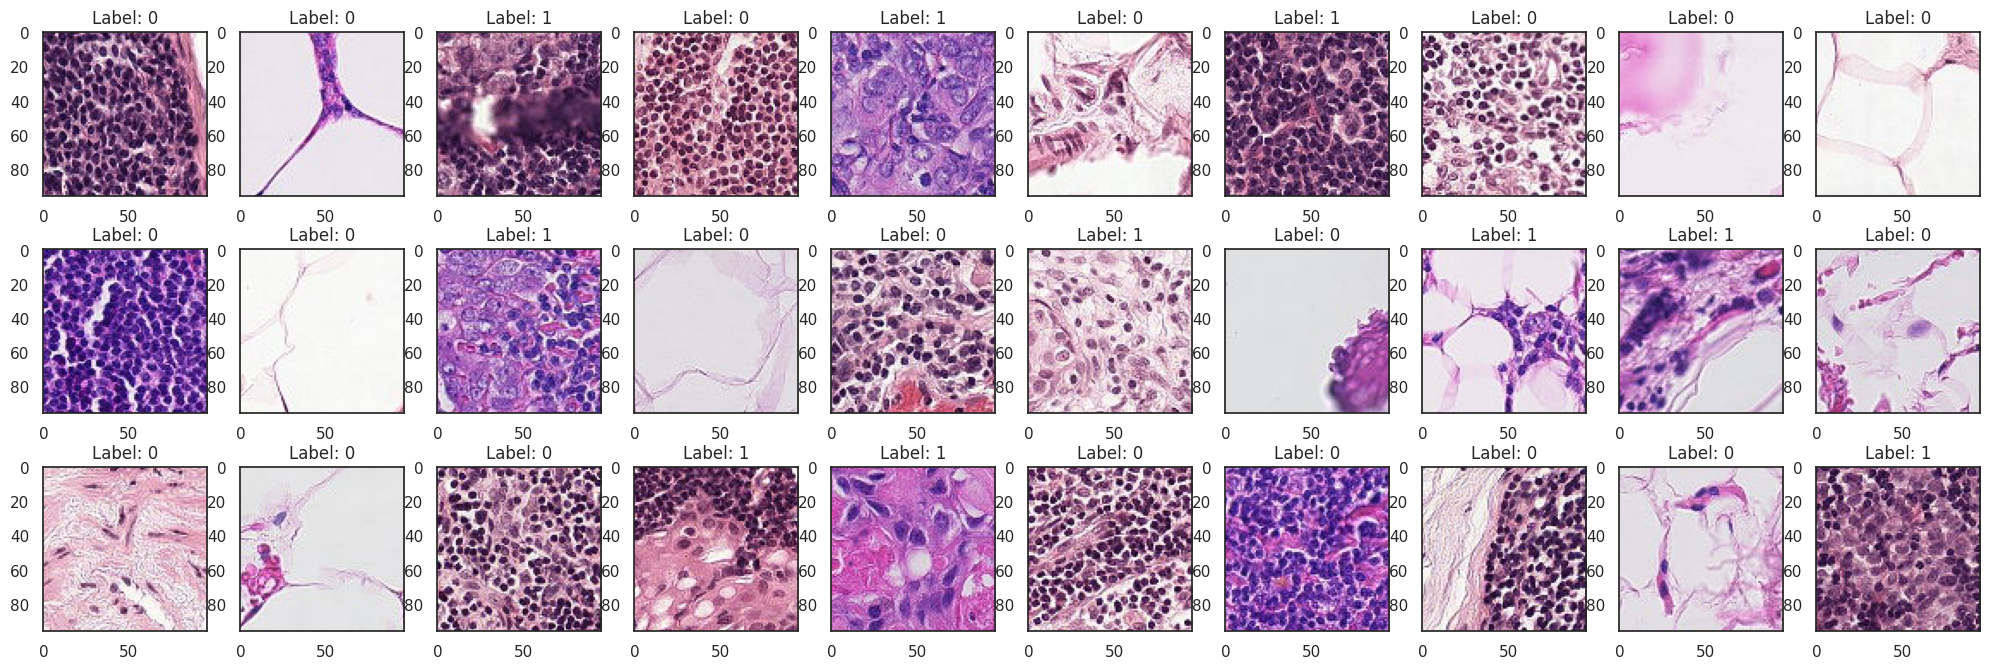

In [ ]:
# create a figure with a size of 25 by 8 inches
fig = plt.figure(figsize=(25, 8))

# set the path to the training data folder
path2data = "data_sample/data_sample"

# get a list of all image files in the training data folder
train_imgs = os.listdir(path2data)

# loop over a randomly chosen subset of 30 images
for idx, img in enumerate(np.random.choice(train_imgs, 30)):

    # add a subplot to the figure
    # specify that there will be 3 rows and 10 columns of subplots
    ax = fig.add_subplot(3, 30//3, idx+1)

    # open the current image file
    im = Image.open(path2data + "/" + img)

    # display the image in the current subplot
    plt.imshow(im)

    # extract the label for the current image from a DataFrame
    # that has a column of image ids and their corresponding labels
    lab = labels_df.loc[labels_df["id"] == img.split('.')[0], 'label'].values[0]

    # set the title of the current subplot to the image label
    ax.set_title(f'Label: {lab}')

In [ ]:
class cancer_dataset(Dataset):
    def __init__(self, data_dir, transform, dataset_type=None):
        # Get the path to the directory containing the images
        path2data = os.path.join(data_dir, "data_sample/data_sample")

        # Get a list of the filenames of the images in the directory
        filenames = os.listdir(path2data)

        # Get the full path to each image
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]

        # Load the labels from a CSV file
        path2labels = os.path.join(data_dir, "/content/drive/MyDrive/sample data/labels.csv")
        labels_df = pd.read_csv(path2labels)

        # Set the "id" column as the index for the labels dataframe
        labels_df.set_index("id", inplace=True)

        # Obtain the labels for the dataset
        if dataset_type=="train":
            # Only use a subset of the images for training
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames][0:3608]
            self.full_filenames = [os.path.join(path2data, f) for f in filenames][0:2608]
            print("training dataset")

        elif dataset_type=="val":
            # Only use a subset of the images for validation
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames][3608:3648]
            self.full_filenames = [os.path.join(path2data, f) for f in filenames][3508:3648]
            print("validation dataset")

        elif dataset_type=="test":
            # Only use a subset of the images for testing
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames][3648:-1]
            self.full_filenames = [os.path.join(path2data, f) for f in filenames][3648:-1]
            print("testing dataset")

        else:
            # Use all the images for the dataset
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]

        # Save the data transformation to be applied to each image
        self.transform = transform

    def __len__(self):
        # Return the size of the dataset (i.e., the number of images)
        return len(self.full_filenames)

    def __getitem__(self, idx):
        # Open the image file and apply the data transformation
        img = Image.open(self.full_filenames[idx]) # PIL image
        img = self.transform(img)

        # Return the transformed image along with its label
        return img, self.labels[idx]

In [ ]:
from torchvision import transforms

# data transformation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
composed_train = transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(degrees=5),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)
                               ])

# this transformation is for valiadationa and test sets
composed= transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)
                               ])

In [ ]:

import os
from os import listdir
from os.path import isfile, join

# Define path to directory
mypath = "/content/drive/MyDrive/sample data/data_sample"

# Get list of only file names in directory
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
# Iterate through each item in list of directory contents returned by listdir function
# Check if item is a file using the isfile function
# If item is a file, add it to the onlyfiles list using the join function to create the full path to the file

In [ ]:
labels_df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [ ]:
# Let's load the dataset and look at a sample
data_dir = "./"
dataset_full = cancer_dataset(data_dir , transform=composed)

In [ ]:
img, label = dataset_full [19]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 224, 224]) tensor(-1.9482) tensor(2.6400)


In [ ]:
# creating the object of cancer_dataset for train, test, and validation
training_set=cancer_dataset(data_dir , transform=composed_train,dataset_type="train")

validation_set=cancer_dataset(data_dir , transform=composed,dataset_type="val")
test_set=cancer_dataset(data_dir , transform=composed,dataset_type="test")
print(f'training dataset length: {len(training_set)}')
print(f'validation dataset length: {len(validation_set)}')
print(f'test dataset length: {len(test_set)}')

training dataset
validation dataset
testing dataset
training dataset length: 2608
validation dataset length: 140
test dataset length: 360


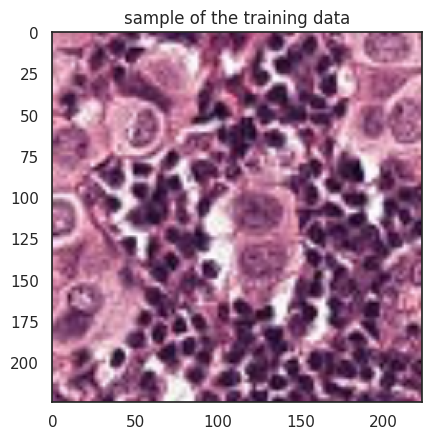

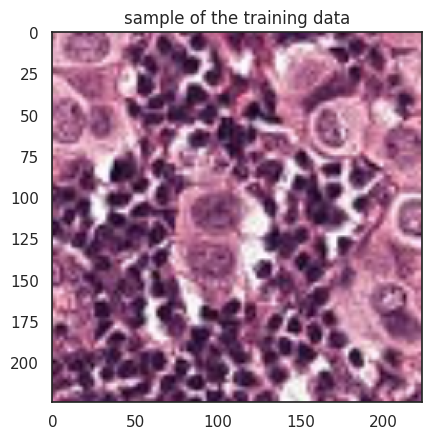

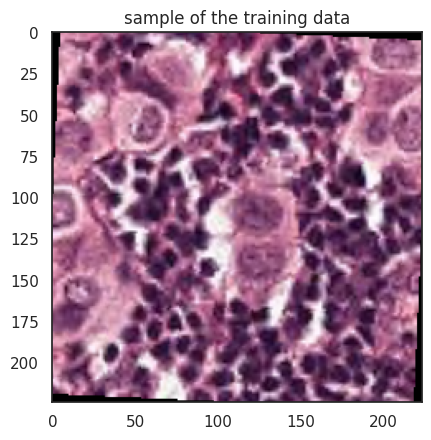

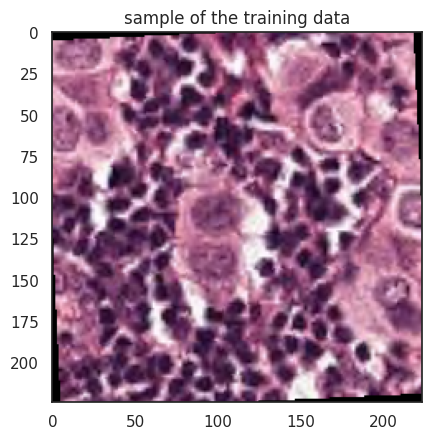

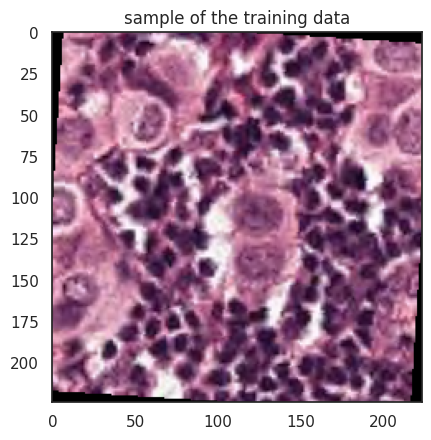

In [ ]:
for i in range(5):
    plt.title("sample of the training data")
    imshow(training_set[2][0])

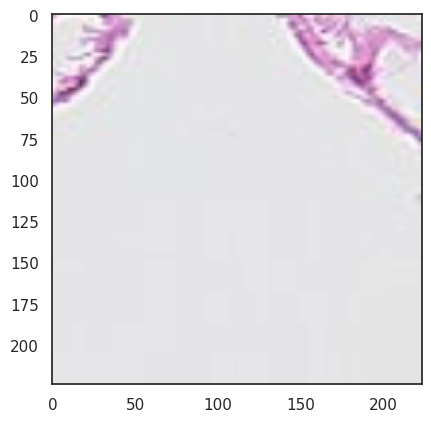

In [ ]:
imshow(test_set[0][0])

In [ ]:
# Load data
train_loader = torch.utils.data.DataLoader(training_set, batch_size=10, shuffle=True, num_workers=2)

# we dont use validation in this project, but it is recommended to use for your future traning procedure
#val_loader = torch.utils.data.DataLoader(validation_set, batch_size=10, shuffle=False, num_workers=2)


test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=False, num_workers=2)

# Define classes
num_classes = 2
print("done")

done


In [ ]:
# Batch size: train set
batch_size = 30

# Learning rate
lr = 3e-4

# Number epochs
n_epochs = 10

In [ ]:
from torchvision import models

model = models.resnet34(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 174MB/s]


In [ ]:
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()

In [ ]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr = lr)

In [ ]:
num_classes = 2
# Load pretrained model
model = models.resnet34(pretrained=True)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False

# Modify last layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

In [ ]:
# Train model

for epoch in range(5): # Loop over a single epoch
    running_loss = 0.0 # Initialize variable to track loss

    # Loop over the training data using a PyTorch DataLoader
    for i, data in enumerate(tqdm(train_loader)):
        # Extract inputs and labels from the data
        inputs, labels = data

        # Zero out the gradients in the optimizer
        optimizer.zero_grad()

        # Forward pass through the model
        outputs = model(inputs)

        # Calculate the loss between the model outputs and labels
        loss = criterion(outputs, labels)

        # Backpropagate the loss and compute gradients
        loss.backward()

        # Update the model parameters using the optimizer
        optimizer.step()

        # Update the running loss with the current batch loss
        running_loss += loss.item()


        # Print the average loss every 100 iterations+
        if i % 100 == 99:
            tqdm.write('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0 # Reset running loss for the next 100 iterations


 38%|███▊      | 100/261 [01:45<02:30,  1.07it/s]

[1,   100] loss: 0.823


 77%|███████▋  | 200/261 [03:32<01:01,  1.01s/it]

[1,   200] loss: 0.826


 38%|███▊      | 100/261 [01:56<03:31,  1.31s/it]

[2,   100] loss: 0.818


 77%|███████▋  | 200/261 [03:51<01:12,  1.19s/it]

[2,   200] loss: 0.819


 38%|███▊      | 100/261 [01:50<02:37,  1.02it/s]

[3,   100] loss: 0.842


 77%|███████▋  | 200/261 [03:38<01:12,  1.19s/it]

[3,   200] loss: 0.821


 38%|███▊      | 100/261 [01:50<03:23,  1.27s/it]

[4,   100] loss: 0.861


 77%|███████▋  | 200/261 [03:36<00:57,  1.06it/s]

[4,   200] loss: 0.823


 38%|███▊      | 100/261 [01:49<03:02,  1.14s/it]

[5,   100] loss: 0.873


 77%|███████▋  | 200/261 [03:38<01:12,  1.20s/it]

[5,   200] loss: 0.794


100%|██████████| 261/261 [04:44<00:00,  1.09s/it]


In [ ]:
# Test the model
correct = 0 # Initialize variable to keep track of correctly classified images
total = 0 # Initialize variable to keep track of total images

# Use the model for inference, and disable gradient tracking
with torch.no_grad():
    for data in tqdm(test_loader): # Loop over the test data using a PyTorch DataLoader
        images, labels = data # Extract images and labels from the data

        # Forward pass through the model to obtain predictions
        outputs = model(images)

        # Find the predicted classes from the model's outputs
        # by taking the class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Update the total count of images seen
        total += labels.size(0)

        # Update the count of correctly classified images
        correct += (predicted == labels).sum().item()

# Compute and print the model's accuracy on the test set
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

100%|██████████| 36/36 [00:38<00:00,  1.06s/it]

Accuracy of the network on the test images: 59 %


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
